In [1]:
import pandas as pd
import matplotlib.pyplot as plt
txt = open('percolatorTab.txt','r').read()

# create list of lists from txt
lines = txt.splitlines()
xs = [l.split('\t') for l in lines]
    
# join the listed proteins if there is more than one
for x in xs:
    while (len(x) > len(xs[0])):
        x[-2:] = [', '.join(x[-2:])]

# create a pandas DataFrame from the acquired data
df = pd.DataFrame(xs[1:], index = range(len(xs[1:])), columns = xs[0])

# Sort by Xcorr
df.sort_values('Xcorr', ascending=False, inplace = True)

# Replace -1 by 0 and turn every element into a number
df = df[df.Label != '-']
df.replace(to_replace = '1', value = 1, inplace = True)
df.replace(to_replace = '-1', value = 0, inplace = True)

# calculate FDR
df['FDR'] = 1 - (df['Label'].cumsum()/[i + 1 for i in range(len(df.index))])

# calculate q-value
df['q-val'] = df['FDR'][::-1].cummin()[::-1]

Diese Kurve ist etwa das was ich aus der E-Mail verstanden habe, geht aber irgendwie in die falsche Richtung:

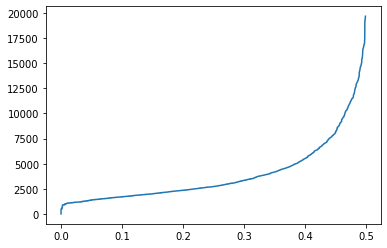

In [11]:
#plt.xlim(0,0.10)
#plt.ylim(0,2000)
plt.plot(df['q-val'],range(len(df.index)))

Diese Kurve ist an der Diagonalen gespiegelt und geht in die richtige Richtung, aber ist wohl trotzdem nicht was ich suche:

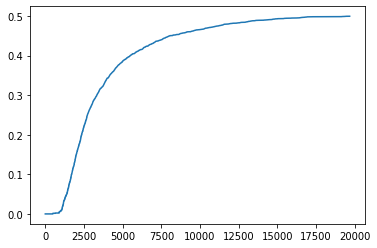

In [3]:
plt.plot(range(len(df.index)),df['q-val'])

Eine ROC-Kurve kommt doch eigentlich aus einem Klassifizierer. Man mal nehme also an, alle decoys sind falsch, alle nicht decoys sind wahr (stimmt natürlich nicht, und für Pseudo-ROC Kurven müssten die wahren und falschen Einträge auch eigentlich jeweils eine Normalverteilung haben). Dann erhält man folgende ROC-Kurve für einen Klassifizierer, der einen q-value als Schwellenwert nimmt und alle Einträge mit einem geringeren q-value als wahr und alle mit einem höheren als falsch klassifiziert:

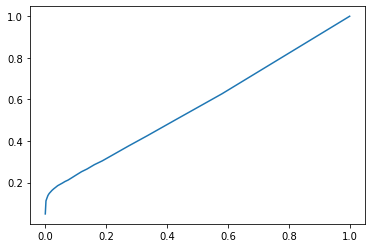

In [4]:
sampleNum = 50
FPR = 0
TPR = 0
FPRs = []
TPRs = []

df.index = [i+1 for i in range(len(df.index))]

# sample values
for qThresh in [i/sampleNum for i in range(sampleNum)]:
    FPR = 0
    TPR = 0
    
    # determine T or F for entries above the threshold
    for i in df.index:
        if (df['q-val'][i] > qThresh):
            break
        if (df['Label'][i] == 1):
            TPR += 1
        else:
            FPR += 1
        
    # calculate FPR and TPR for this threshold
    P = sum(df['Label'])
    N = len(df['Label']) - P
    FPR = FPR / N
    TPR = TPR / P
    
    # save FPR and TPR in respective lists
    FPRs.append(FPR)
    TPRs.append(TPR)

# plot ROC curve for this method
plt.plot(FPRs,TPRs)

Da dabei die Klassifizierung in echt wahr bzw. echt falsch nicht gut funktioniert, habe ich mich noch mit den Verteilungen von targets und decoys beschäftigt. Vermutlich hätte es auch eingebaute histogram funktionen gegeben, auf Anhieb habe ich aber keine passende gefunden. Der Graph am Ende zeigt das Verhältnis targets zu decoys in Abhängigkeit vom Xcorr-Score. Man sieht, dass es etwa gleich viele targets wie decoys im Bereich der niedrigen Xcorr-Scores gibt, bei hohen Xcorr-Scores sind es dagegen nur noch targets. Ich konnte keine Schlüsse ziehen, welche Einträge man als wahr oder falsch vermuten sollte. Denn selbst wenn man aus dieser Auftragung echte Wahrscheinlichkeiten ableiten könnte, ist im Grenzbereich jeder target-Eintrag auch nur zu einer bestimmten Wahrscheinlichkeit wahr.

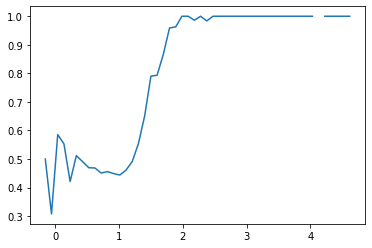

In [5]:
# create histograms for 2 lists with the same buckets
def myHist(lst1, lst2, bins = 10):
    mn = min(min(lst1, lst2))
    step = (max(max(lst1, lst2))-mn)/bins
    xTick = [mn + (i * step) for i in [j + 0.5 for j in range(bins)]]
    return [xTick, fillHist(lst1,mn,step,bins), fillHist(lst2,mn,step,bins)]

# create histogram for one list
def fillHist(lst, mn, step, bins):
    hist = [0] * bins
    for i in lst:
        t = mn + step
        while (i > t):
            t = t + step
        hist[(int) (((t-mn) / step) - 1)] += 1
    return hist

targets = [float(df['Xcorr'][i]) for i in df.index if (df['Label'][i] == 1)]
decoys = [float(df['Xcorr'][i]) for i in df.index if (df['Label'][i] == 0)]

# acquire histograms for targets and decoys
r = myHist(targets, decoys, bins = 50)
x = r[0]
targHist = r[1]
decoHist = r[2]

# plot difference of target and decoy distribution
#plt.plot(x,[t-d for t,d in zip(targHist,decoHist)])

# plot ratio of targets to decoys
y = []
for t,d in zip(targHist,decoHist):
    if (t == 0 and d == 0):
        y += [float('NaN')]
    else:
        y += [t/(t+d)]
        
plt.plot(x,y)

Zu spät ist mir aufgefallen, dass ich das gleiche in der FDR ausgerechnet habe. Der folgende Graph zeigt die FDR-Werte in Abhängigkeit vom Xcorr-Score und an y = 0.5 gespiegelt, um die selben Zahlenwerte zu haben.

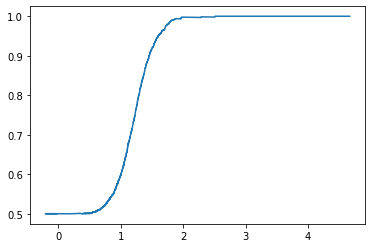

In [6]:
x = [float(x) for x in df['Xcorr']]
y = [-float(x) + 1 for x in df['FDR']]
plt.plot(x, y)